# Matching PSF's

Because images taken at different times in different bands will have widely varying PSF's, it is often necessary to convolve the images to a common PSF to ensure that every source has the same morphology in each band.
One way to solve this problem is to created PSF matched co-adds that are passed to *SCARLET* as input images.
The drawback to this solution is that bands with smaller PSFs are likely to have less blending, which is better for constraining their shapes.

This tutorial is designed to show how to create a model that uses a different PSF in each band, including showing one way to create difference kernels using *SCARLET* and illustrating why partially deconvolving using difference kernels is the correct way to approach this problem.

In [1]:
# Import Packages and setup
import os
import logging
from astropy.table import Table as ApTable

import numpy as np

import scarlet
import scarlet.display

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')

## Load and display the sample data

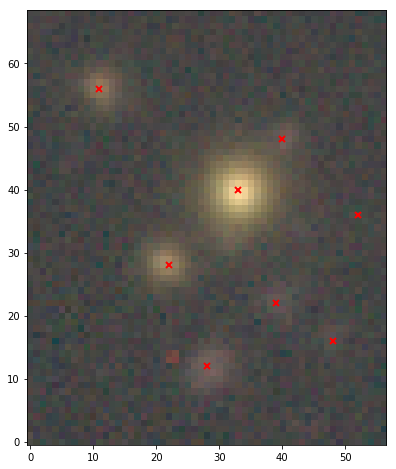

In [2]:
# Load a real HSC-Cosmos blend with a different PSF in each band
datapath = '../data/real_data/hsc_cosmos'
files = os.listdir(datapath)
data = np.load(os.path.join(datapath, files[0]))
images = data["images"]
psfs = data["psfs"]
peaks = data["peaks"]
weights = data["weights"]

# Estimate the background RMS
bg_rms = np.sqrt(np.std(images, axis=(1,2))**2 + np.median(images, axis=(1,2))**2)

# Use Asinh scaling for the images
vmin, vmax = scarlet.display.zscale(images, fraction=.75)
norm = scarlet.display.Asinh(Q=50, vmin=vmin, vmax=vmax)
    
# Map i,r,g -> RGB
filter_indices = [3,2,1]
# Convert the image to an RGB image
img_rgb = scarlet.display.img_to_rgb(images, filter_indices=filter_indices, norm=norm)
plt.figure(figsize=(8,8))
plt.imshow(img_rgb)
for peak in peaks:
    plt.plot(peak[0], peak[1], "rx", mew=2)
plt.show()

## No Convolution

We first run *SCARLET* without convolving the sources with the PSF in each band.
Notice that not all of the sources in our catalog have flux above the noise level, so we do not add those peaks to our list of sources to deblend by catching the `SourceInitError` that is thrown.

In [3]:
sources = []
for n,peak in enumerate(peaks):
    try:
        result = scarlet.ExtendedSource((peak[1], peak[0]), images, bg_rms)
        sources.append(result)
    except scarlet.source.SourceInitError:
        print("No flux in peak {0} at {1}".format(n, peak))
blend = scarlet.Blend(sources).set_data(images, bg_rms=bg_rms)
blend.fit(100, e_rel=.015)
print("scarlet ran for {0} iterations".format(blend.it))

No flux in peak 7 at [ 52.  36.]
scarlet ran for 89 iterations


In [4]:
def display_model_residual(images, blend, norm):
    """Display the data, model, and residual for a given result
    """
    model = blend.get_model()
    residual = images-model
    print("Data range: {0:.3f} to {1:.3f}\nresidual range: {2:.3f} to {3:.3f}\nrms: {4:.3f}".format(
        np.min(images),
        np.max(images),
        np.min(residual),
        np.max(residual),
        np.sqrt(np.std(residual)**2+np.mean(residual)**2)
    ))
    # Create RGB images
    img_rgb = scarlet.display.img_to_rgb(images, filter_indices=filter_indices, norm=norm)
    model_rgb = scarlet.display.img_to_rgb(model, filter_indices=filter_indices, norm=norm)
    residual_norm = scarlet.display.Linear(img=residual)
    residual_rgb = scarlet.display.img_to_rgb(residual, filter_indices=filter_indices, norm=residual_norm)

    # Show the data, model, and residual
    fig = plt.figure(figsize=(15,5))
    ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
    ax[0].imshow(img_rgb)
    ax[0].set_title("Data")
    ax[1].imshow(model_rgb)
    ax[1].set_title("Model")
    ax[2].imshow(residual_rgb)
    ax[2].set_title("Residual")
    for k,component in enumerate(blend.components):
        y,x = component.center
        px, py = peaks[k]
        ax[0].plot(x, y, "gx")
        ax[0].plot(px, py, "rx")
        ax[1].text(x, y, k, color="r")
    plt.show()

In this particular case the PSFs in each band are not that different, so the model does a decent job matching the data.
However, notice the slight color variations in the data, especially green in the brighter object, that are flat in the model.
The model also contains spiky fractal-like structures that are unphysical, due to overfitting the noise.

Data range: -0.504 to 15.331
residual range: -2.358 to 2.043
rms: 0.110


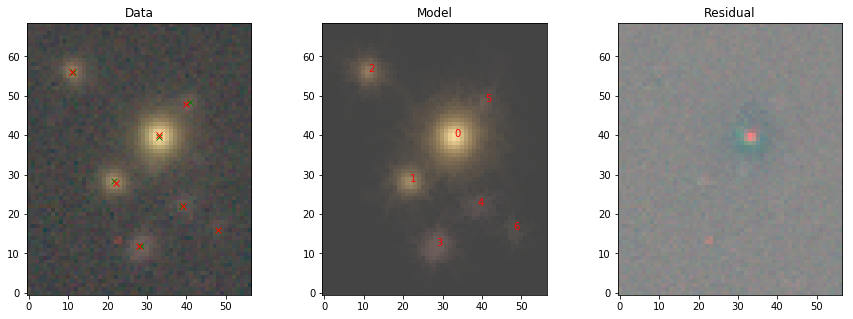

In [5]:
display_model_residual(images, blend, norm)

## Full PSF Deconvolution

When using a PSF for each band, the morphology (`Source.morph`) for each object is the deconvolved morphology, which is combined with the PSF in each band to reproduce the data.
However, full de-convolution in a noisy image is not a well defined operation and in practice often results in unphysical biases in the data.
To illustrate this point we first attempt to fully deconvolve the morphology by using the PSF in each band to convolve the sources.

No flux in peak 7 at [ 52.  36.]


scarlet ran for 100 iterations
Data range: -0.504 to 15.331
residual range: -1.018 to 2.374
rms: 0.105


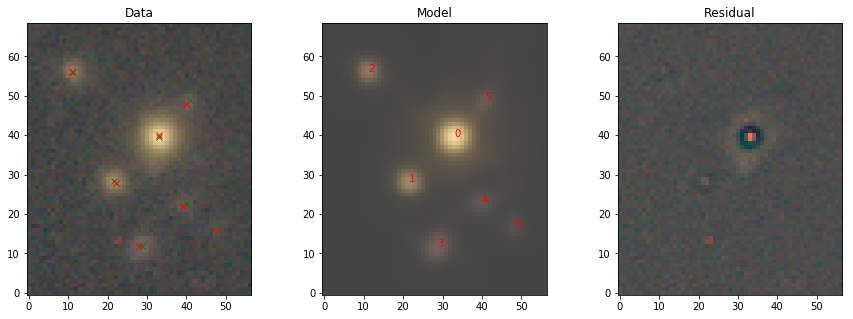

In [6]:
sources = []
for n,peak in enumerate(peaks):
    try:
        result = scarlet.ExtendedSource((peak[1], peak[0]), images, bg_rms, psf=psfs)
        sources.append(result)
    except:
        print("No flux in peak {0} at {1}".format(n, peak))

blend_psf = scarlet.Blend(sources).set_data(images, bg_rms=bg_rms)
blend_psf.fit(100, e_rel=.015)
print("scarlet ran for {0} iterations".format(blend_psf.it))
display_model_residual(images, blend_psf, norm)

Notice that source 0, which should be roughly spherical, has sharp gradients on the right and left sides. This is not a real physical effect but a consequence of trying to fully deconvolve the image. Similarly, all of the sources have slight rings around them int he residuals, indicating that PSF deconvolution did not work as expected.

## Partial PSF Deconvolution

Instead of trying to fully deconvolve the images, we can perform a partial convolution by matching each band to a smaller target PSF.
A convenience function [psf_match_fit](psf_match.ipynb#scarlet.psf_match.psf_match_fit) can be used to fit each PSF in the collection of PSFs to a target function, for example a [moffat](psf_match.ipynb#scarlet.psf_match.moffat), [gaussian](psf_match.ipynb#scarlet.psf_match.gaussian), or [double gaussian](psf_match.ipynb#scarlet.psf_match.double_gaussian), and then use the resulting best fit parameters to create a smaller target PSF.

In [7]:
import imp
imp.reload(scarlet)
import scarlet.psf_match
imp.reload(scarlet.psf_match)

<module 'scarlet.psf_match' from '/Users/pmelchior/Library/Enthought/Canopy/edm/envs/User/lib/python3.5/site-packages/scarlet-0.3.9771403-py3.5-macosx-10.6-x86_64.egg/scarlet/psf_match.py'>

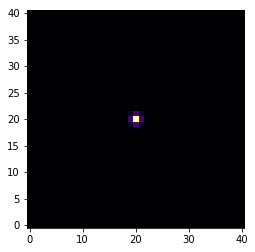

In [8]:
target_psf = scarlet.psf_match.fit_target_psf(psfs, scarlet.psf_match.moffat)
plt.imshow(target_psf)

### Building the Difference Kernels

The most time consuming operation in *SCARLET* is the PSF convolution, where the runtime scales linearly with the number of pixels used in the PSF.
So ideally we want the fewest number of pixels in each difference kernal to accurately reporoduce the target PSF.
One way this can be done is to use the existing framework of *SCARLET* to simultaneously match the PSF in each band to the same `target_psf` calculated above using the [build_diff_kernels](psf_match.ipynb#scarlet.psf_match.build_diff_kernels) function.
This function basically models each PSF as a source with a fixed SED, so that each PSF only has the SED in it's band turned on.
The `target_psf` is used to convolve the "morphology" of the difference kernal so that it matches the "data", the input PSF in each band, by applying an L0 sparsity penalty to minimize the number of pixels needed in each band.
So the resulting `morph` for each "source" is the difference kernel in that band.

In [9]:
diff_kernels, psf_blend = scarlet.psf_match.build_diff_kernels(psfs, target_psf)

We can compare each psf in `psfs` to the model create when convolving it's `difference_kernel` with `target_psf`

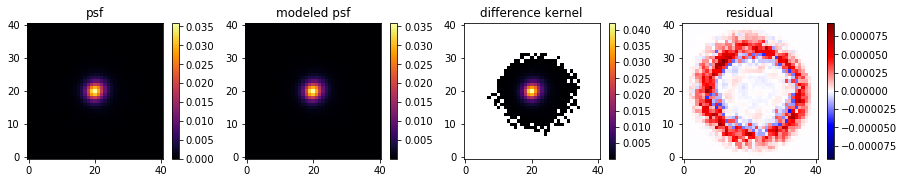

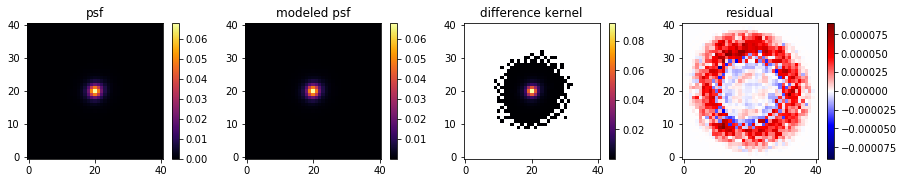

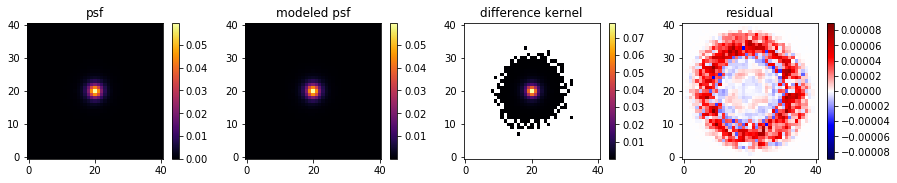

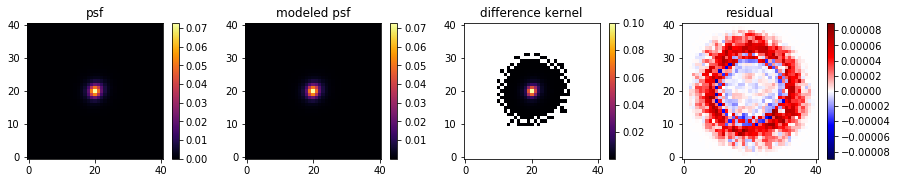

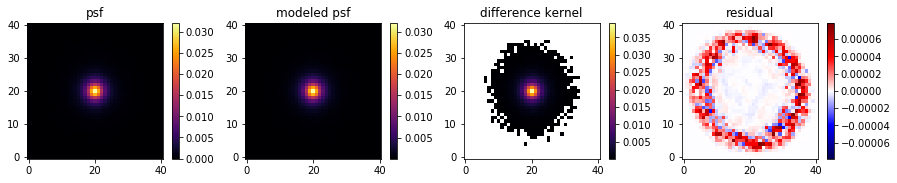

In [10]:
rgb_map = [3,2,1]
model = psf_blend.get_model()
for b, component in enumerate(psf_blend.components):
    fig = plt.figure(figsize=(15,2.5))
    ax = [fig.add_subplot(1,4,n+1) for n in range(4)]
    # Display the psf
    ax[0].set_title("psf")
    _img = ax[0].imshow(psfs[b])
    fig.colorbar(_img, ax=ax[0])
    # Display the model
    ax[1].set_title("modeled psf")
    _model = np.ma.array(model[b], mask=model[b]==0)
    _img = ax[1].imshow(_model)
    fig.colorbar(_img, ax=ax[1])
    # Display the difference kernel
    ax[2].set_title("difference kernel")
    _img = ax[2].imshow(np.ma.array(diff_kernels[b], mask=diff_kernels[b]==0))
    fig.colorbar(_img, ax=ax[2])
    # Display the residual
    ax[3].set_title("residual")
    residual = psfs[b]-model[b]
    vabs = np.max(np.abs(residual))
    _img = ax[3].imshow(residual, vmin=-vabs, vmax=vabs, cmap='seismic')
    fig.colorbar(_img, ax=ax[3])
    plt.show()

Even though the pixels used in the difference kernels is different for each band, the L0 sparsity constraint and relative error ensure that the difference kernels match up to the desired precision.

### Deblend using the difference kernels

Now we can use the difference kernals as the input `psf` for each [Source](source.ipynb#scarlet.source.Source)

In [11]:
sources = []
images = data["images"]
bg_rms = np.sqrt(np.std(images, axis=(1,2))**2 + np.median(images, axis=(1,2))**2)
print(bg_rms)
for n,peak in enumerate(peaks):
    try:
        result = scarlet.ExtendedSource((peak[1], peak[0]), images, bg_rms, psf=diff_kernels)
        sources.append(result)
    except:
        print("No flux in peak {0} at {1}".format(n, peak))

blend_diff = scarlet.Blend(sources).set_data(images, bg_rms=bg_rms)
blend_diff.fit(100, e_rel=.015)
print("scarlet ran for {0} iterations".format(blend_diff.it))

[ 0.0493521   0.13865101  0.4235658   0.72557634  0.6836471 ]
No flux in peak 7 at [ 52.  36.]
scarlet ran for 86 iterations


When we look at the results we see that the artifacts introduced by full deconvolution have largely vanished, as well as the rings around all of the objects other than the bright central galaxy (source 0). But in this case the red core is an indication that this galaxy should probably be modeled as two components, a redder bulge and bluer disk.

Data range: -0.504 to 15.331
residual range: -0.792 to 1.432
rms: 0.098


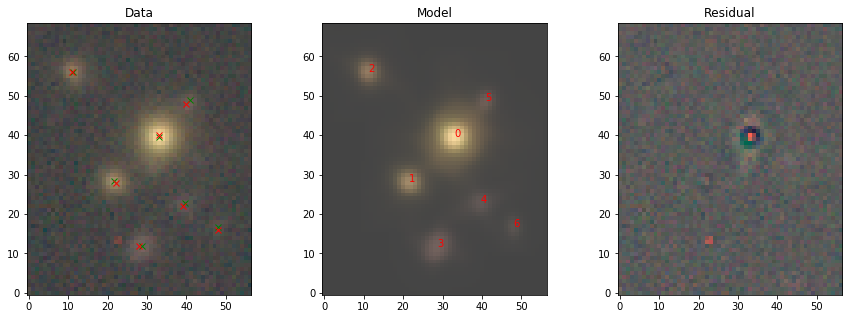

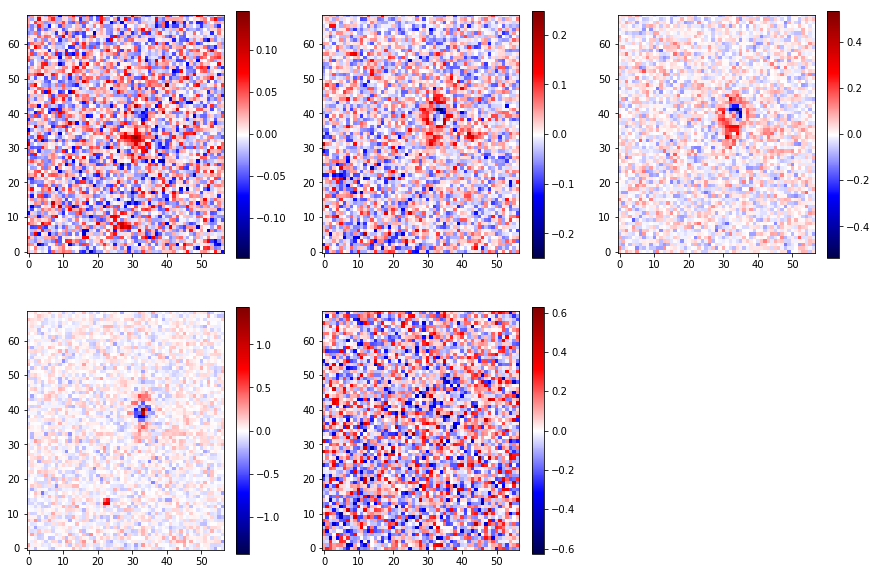

In [12]:
display_model_residual(images, blend_diff, norm)
# display the total residual in each band
model = blend_diff.get_model()
residuals = images-model
fig = plt.figure(figsize=(15,10))
ax = [fig.add_subplot(2,3,n+1) for n in range(len(model))]
for b in range(len(model)):
    vabs = np.max(np.abs(residuals[b]))
    _img = ax[b].imshow(residuals[b], vmin=-vabs, vmax=vabs, cmap='seismic')
    fig.colorbar(_img, ax=ax[b])
plt.show()

When we compare the results using the different deblending techniques we see the clear advantage to using the difference kernels

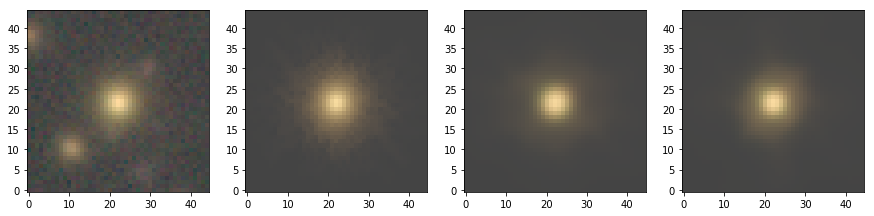

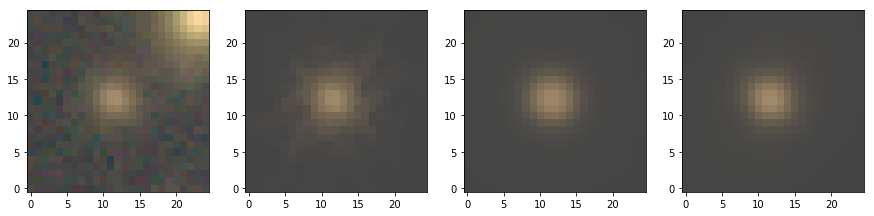

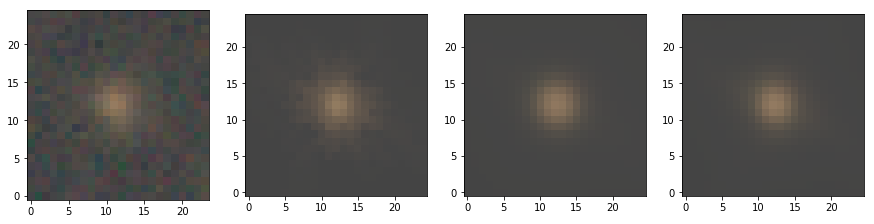

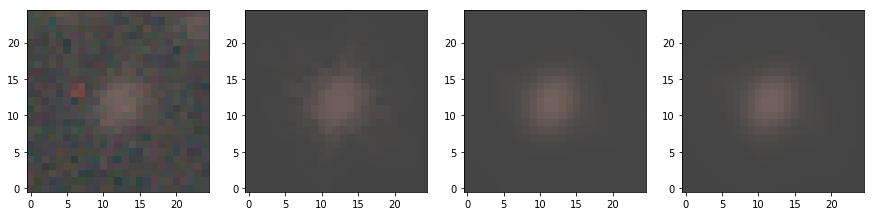

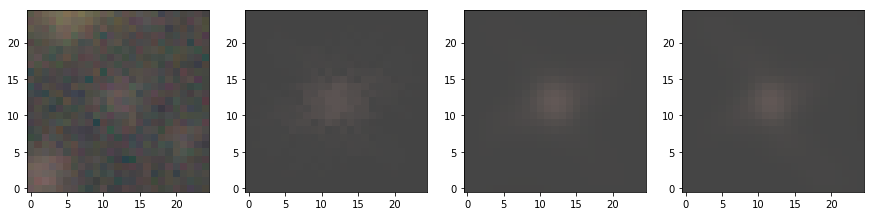

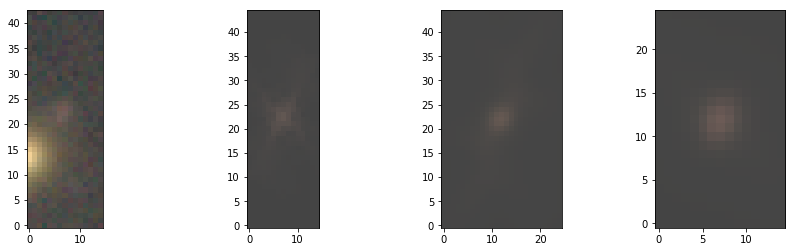

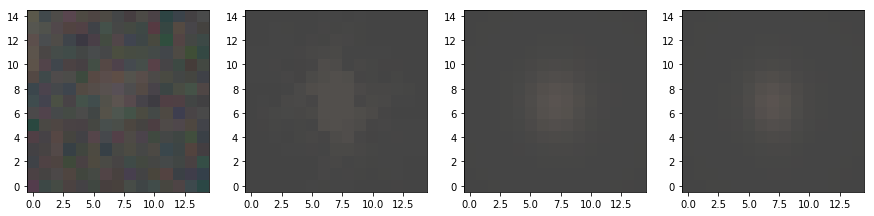

In [13]:
for b in range(len(blend_diff.components)):
    model = blend[b].get_model()
    model_psf = blend_psf[b].get_model()
    model_diff = blend_diff[b].get_model()
    img = images[blend[(b,0)].bb]
    # Create RGB images
    vmin, vmax = scarlet.display.zscale(img, fraction=.75)
    img_rgb = scarlet.display.img_to_rgb(img, filter_indices=filter_indices, norm=norm)
    model_rgb = scarlet.display.img_to_rgb(model, filter_indices=filter_indices, norm=norm)
    model_psf_rgb = scarlet.display.img_to_rgb(model_psf, filter_indices=filter_indices, norm=norm)
    model_diff_rgb = scarlet.display.img_to_rgb(model_diff, filter_indices=filter_indices, norm=norm)
    fig = plt.figure(figsize=(15,4))
    ax = [fig.add_subplot(1,4,n+1) for n in range(4)]
    ax[0].imshow(img_rgb)
    ax[1].imshow(model_rgb)
    ax[2].imshow(model_psf_rgb)
    ax[3].imshow(model_diff_rgb)
    plt.show()